https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
https://colab.research.google.com/drive/109vu3F1LTzD1gdVV6cho9fKGx7lzbFll#scrollTo=8q8a2Ha9pnaz

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_style('whitegrid')

In [2]:
from src.utils import show_data_samples
import torchvision
import PIL
from PIL import Image
from torch.utils.data import DataLoader, Dataset

# Dataset class
`torch.utils.data.Dataset` is an abstract class representing a dataset. Your custom dataset should inherit Dataset and override the following methods:

- `__len__` so that len(dataset) returns the size of the dataset.
- `__getitem__` to support the indexing such that dataset[i] can be used to get ith sample

Let’s instantiate this class and iterate through the data samples. 

In [3]:
class DogBreedDataset(Dataset):
    """Dog Breed dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        im_path = os.path.join(self.root_dir, self.data.iloc[idx]['id'] + '.jpg')
        image = Image.open(im_path)

        data_sample = {
            'image': image,
            'label': self.data.iloc[idx]['breed_label'],
            'label_name': self.data.iloc[idx]['breed']
        }

        if self.transform:
            data_sample['image'] = self.transform(image)

        return data_sample

In [4]:
dog_breed_train = DogBreedDataset(
    csv_file='processed_data/train_train_dataset.csv', 
    root_dir='data/train')

In [5]:
display(dog_breed_train.data.head())

id            breed  breed_label
0  8e11ed7d590db5f624fc248051dfa485  standard_poodle          105
1  bd67952d62b23e87a420c8c80fd99756       otterhound           83
2  c3b7f884bf97c8caa64377672521a7b0       rottweiler           91
3  7671fa917628bbe067eb4f63e5003ca7      appenzeller            5
4  261ee1f32174c1ce20aa3ae952f5604e         airedale            3

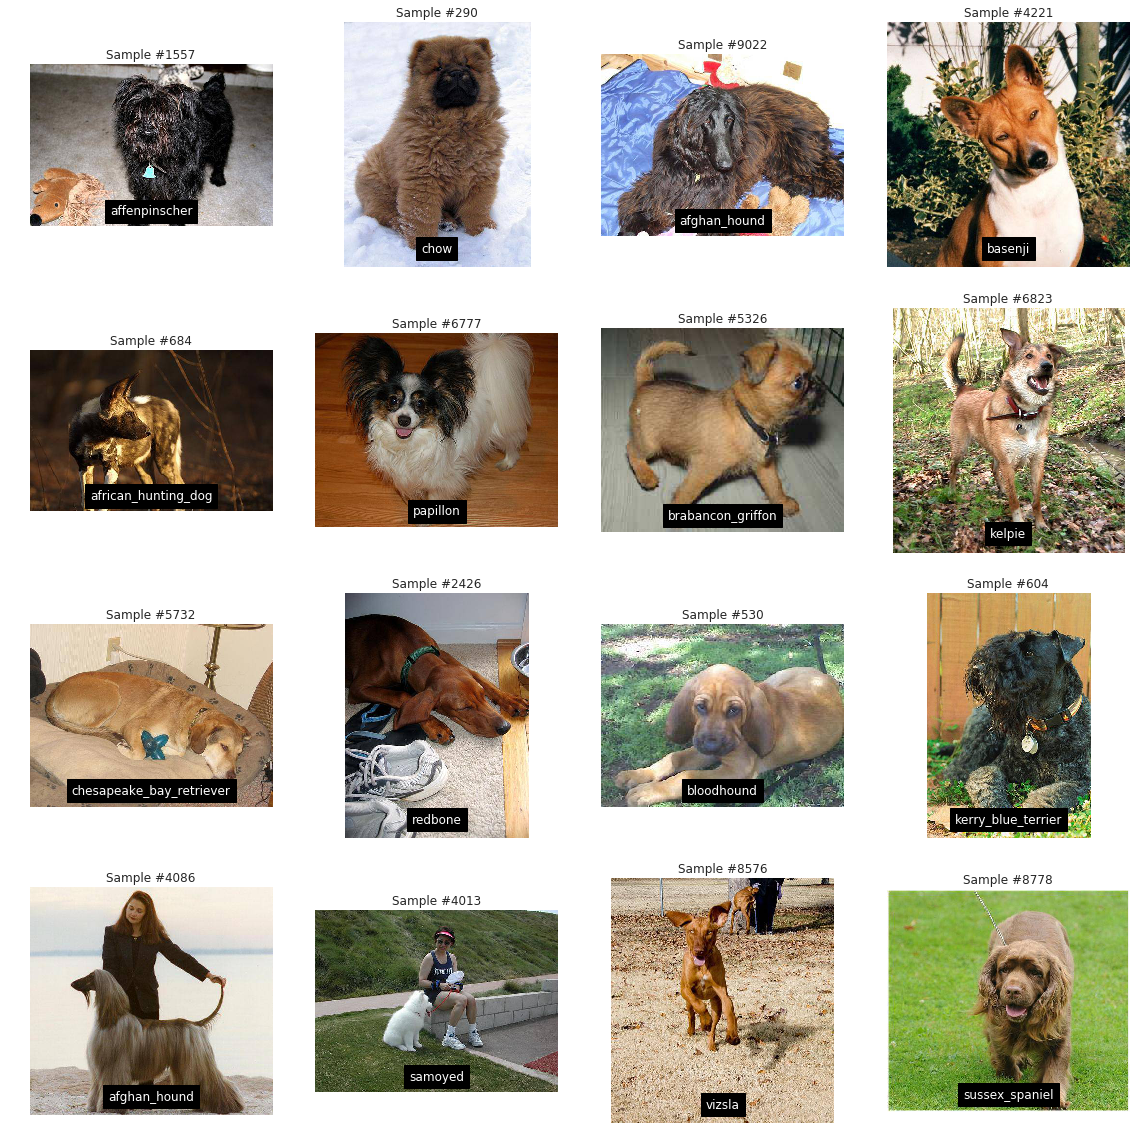

In [6]:
train_sample_indices = np.random.choice(a=np.arange(len(dog_breed_train)), size=16, replace=False)
show_data_samples(sample_indices=train_sample_indices, dataset=dog_breed_train)

# Transforms: from torchvision
### Always viewing the augmented images before applying on the whole dataset
Let's write some simple data augmentation codes.

In [7]:
simple_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(20, resample=PIL.Image.BILINEAR)
])

In [8]:
dog_breed_train_aug = DogBreedDataset(
    csv_file='processed_data/train_train_dataset.csv', 
    root_dir='data/train', transform=simple_transforms)
print(dog_breed_train_aug[25].keys())

dict_keys(['image', 'label', 'label_name'])


In [9]:
sample_indices = np.random.choice(np.arange(len(dog_breed_train_aug)), 4, replace=False)
sample_indices = np.repeat(sample_indices, 4)
print(sample_indices)

[4270 4270 4270 4270 2801 2801 2801 2801 1938 1938 1938 1938 8207 8207
 8207 8207]


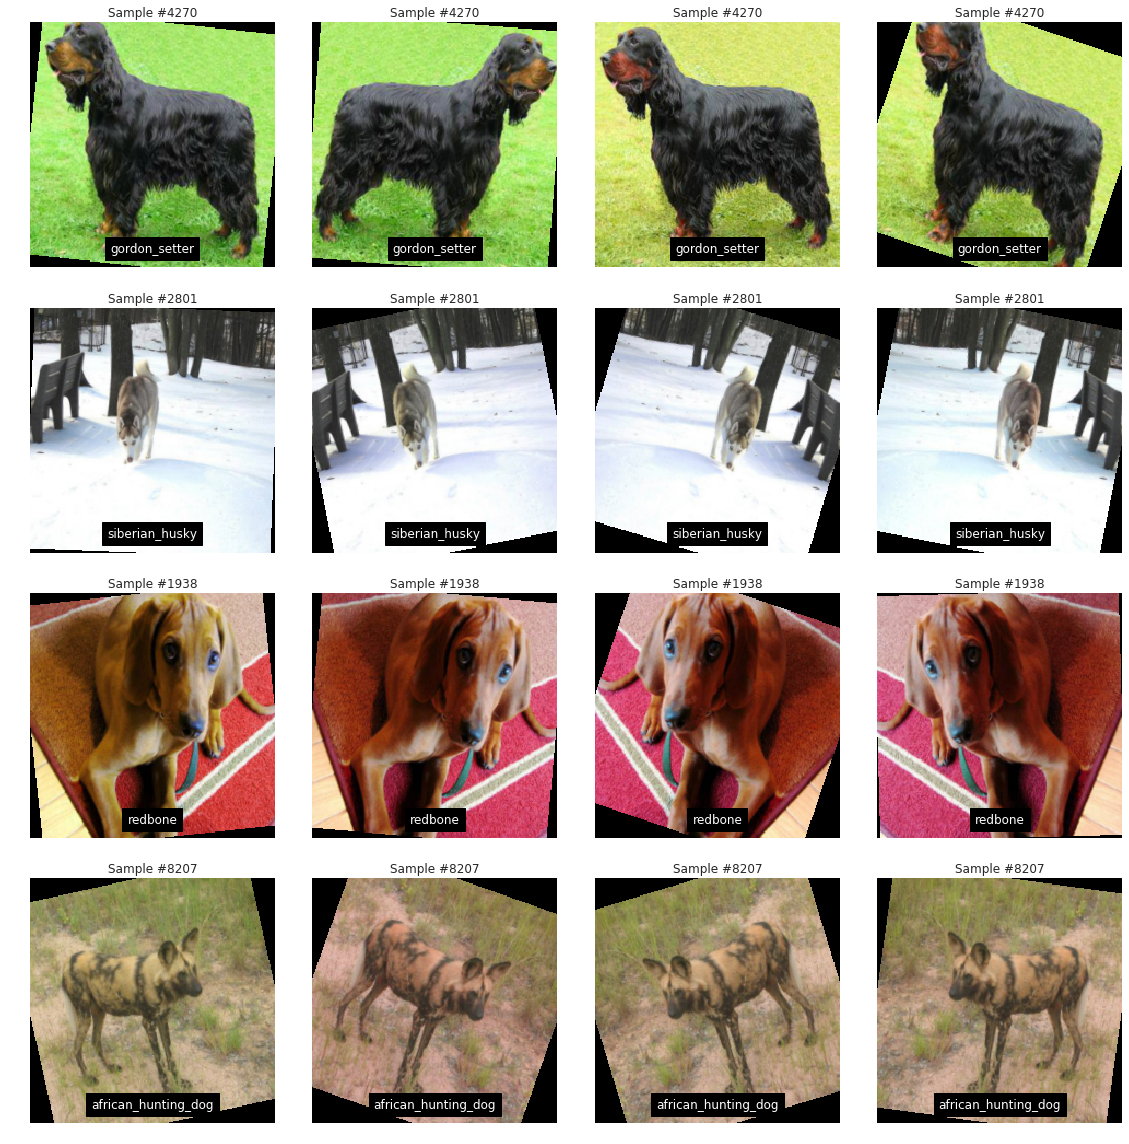

In [10]:
show_data_samples(sample_indices=sample_indices, dataset=dog_breed_train_aug)

# advanced augmentation
We can also use other image augmentation packages. For example: [imgaug](https://github.com/aleju/imgaug)

In [11]:
from imgaug import augmenters as iaa
import imgaug as ia

In [29]:
class ImgAugTransform(object):
    def __init__(self):
        self.aug = iaa.Sequential([
            iaa.Scale((224, 224)),
            iaa.Sometimes(0.25, iaa.OneOf([
                iaa.GaussianBlur(sigma=(0, 3.0)),
                iaa.AverageBlur(k=(1, 5)),
                iaa.MedianBlur(k=(1, 5))
            ])),
            iaa.Fliplr(p=0.5),
            iaa.Affine(rotate=(-20, 20), mode='symmetric'),
            iaa.Sometimes(0.25, iaa.OneOf([
                iaa.Dropout(p=(0, 0.1)),
                iaa.Add((-20, 20)),
                iaa.SaltAndPepper(p=0.01),
            ])),
            iaa.Sometimes(0.25, iaa.OneOf([
                iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True),
                iaa.Grayscale(alpha=(0, 1.0))
            ])),
            iaa.GammaContrast(gamma=(0.5, 1.5))
        ])
        
    def __call__(self, img):
        img = np.array(img)
        return self.aug.augment_image(img)

In [30]:
imgaug_transforms = ImgAugTransform()
dog_breed_train_imgaug = DogBreedDataset(
    csv_file='processed_data/train_train_dataset.csv', 
    root_dir='data/train', transform=imgaug_transforms)

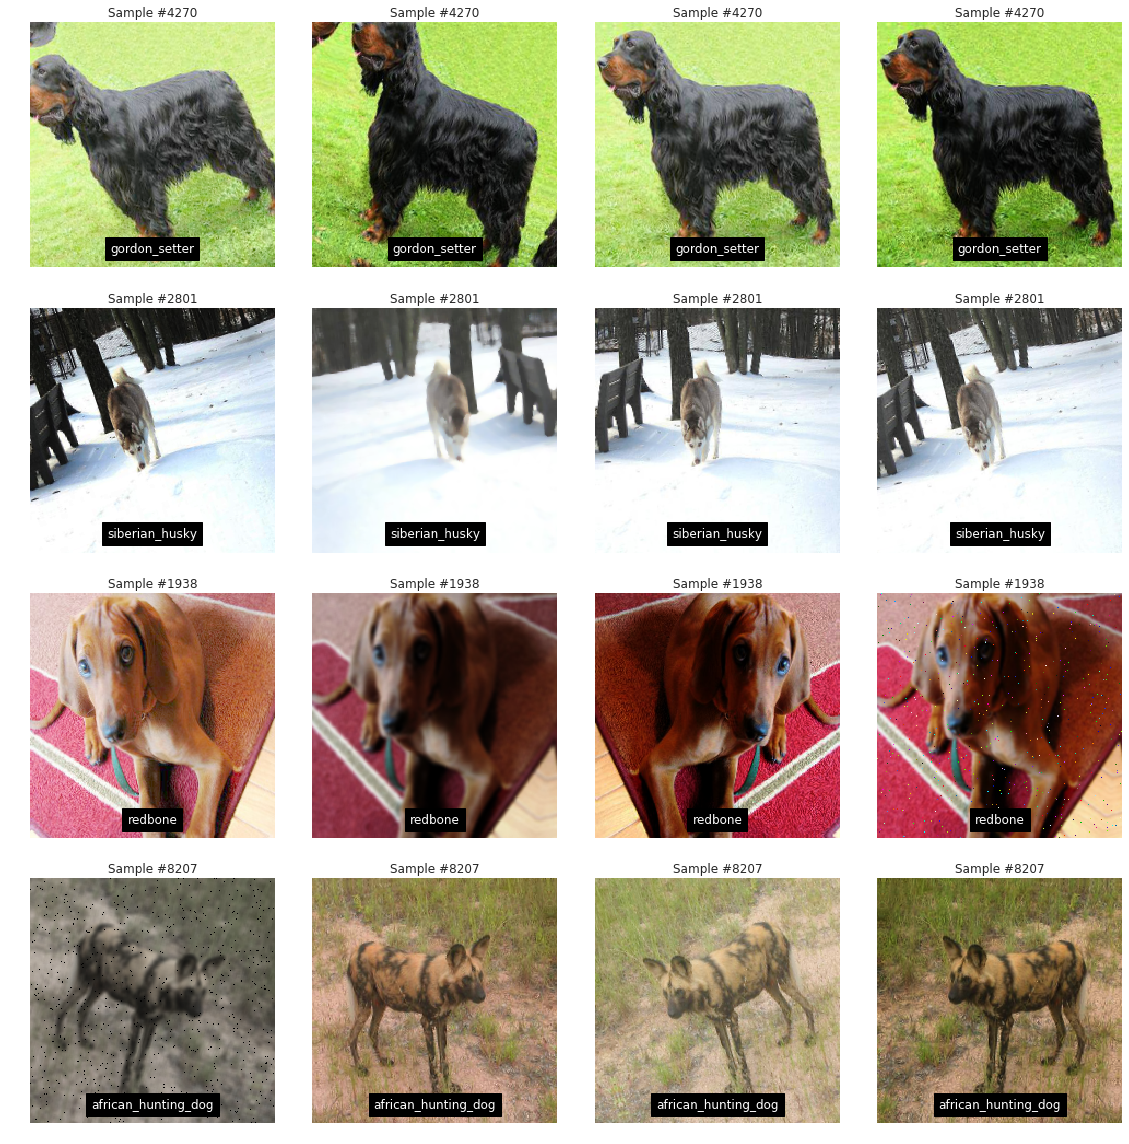

In [31]:
show_data_samples(sample_indices=sample_indices, dataset=dog_breed_train_imgaug)

# DataLoader
You need to combine dataset and transform so you can efficiently generate data samples in batch during model training. For training we need to add `transforms.ToTensor` to convert the images to a PyTorch Tensor and `transforms.Normalize` to normalize the images according to the network that you will train.

In [15]:
class FinalTransform(object):
    def __init__(self):
        self.aug = iaa.Sequential([
            iaa.Scale((224, 224)),
            iaa.Sometimes(0.25, iaa.OneOf([
                iaa.GaussianBlur(sigma=(0, 3.0)),
                iaa.AverageBlur(k=(1, 5)),
                iaa.MedianBlur(k=(1, 5))
            ])),
            iaa.Fliplr(p=0.5),
            iaa.Affine(rotate=(-20, 20), mode='symmetric'),
            iaa.Sometimes(0.25, iaa.OneOf([
                iaa.Dropout(p=(0, 0.1)),
                iaa.Add((-20, 20)),
                iaa.SaltAndPepper(p=0.01),
            ])),
            iaa.Sometimes(0.25, iaa.OneOf([
                iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True),
                iaa.Grayscale(alpha=(0, 1.0))
            ])),
            iaa.GammaContrast(gamma=(0.5, 1.5))
        ])
        
    def __call__(self, img):
        img = np.array(img)
        img_aug = self.aug.augment_image(img)
        
        to_tensor = torchvision.transforms.ToTensor()
        img_aug = to_tensor(img_aug)
        
        return img_aug

In [16]:
dog_breed_train_aug_final = DogBreedDataset(
    csv_file='processed_data/train_train_dataset.csv', 
    root_dir='data/train', transform=FinalTransform())
dog_breed_train_loader = DataLoader(dog_breed_train_aug_final, batch_size=16, shuffle=True, num_workers=4)

In [17]:
for batch_idx, batch_data in enumerate(dog_breed_train_loader):
    print(batch_idx, batch_data['image'].size(), batch_data['label'].size())
    
    if batch_idx >= 1:
        break

0 torch.Size([16, 3, 224, 224]) torch.Size([16])
1 torch.Size([16, 3, 224, 224]) torch.Size([16])


In [32]:
batch_data['image'][0]

tensor([[[0.2941, 0.2941, 0.2902,  ..., 0.2627, 0.2588, 0.2549],
         [0.2824, 0.2863, 0.2863,  ..., 0.2667, 0.2627, 0.2627],
         [0.2627, 0.2667, 0.2706,  ..., 0.2706, 0.2706, 0.2706],
         ...,
         [0.3922, 0.4000, 0.4039,  ..., 0.4745, 0.4667, 0.4235],
         [0.3843, 0.3882, 0.3961,  ..., 0.4706, 0.4471, 0.4235],
         [0.3843, 0.3843, 0.3843,  ..., 0.4784, 0.4431, 0.4000]],

        [[0.0627, 0.0588, 0.0627,  ..., 0.0745, 0.0706, 0.0667],
         [0.0667, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0706],
         [0.0667, 0.0667, 0.0667,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1647, 0.1686, 0.1804,  ..., 0.2314, 0.2196, 0.1961],
         [0.1490, 0.1529, 0.1490,  ..., 0.2353, 0.2118, 0.1843],
         [0.1529, 0.1490, 0.1529,  ..., 0.2431, 0.2157, 0.1961]],

        [[0.0039, 0.0000, 0.0039,  ..., 0.0039, 0.0000, 0.0000],
         [0.0118, 0.0078, 0.0078,  ..., 0.0039, 0.0000, 0.0000],
         [0.0157, 0.0157, 0.0157,  ..., 0.0000, 0.0000, 0.